In [1]:
from squlearn.feature_map.qcnn_feature_map import qcnn_feature_map
from squlearn.feature_map.qcnn_feature_map import prototype_routine

from squlearn.util import Executor

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

import numpy as np
import itertools
import random

from squlearn.expectation_operator import SingleAmplitude
from squlearn.qnn import QNN
from squlearn.feature_map.layered_feature_map import LayeredFeatureMap
from qiskit.primitives import Estimator

from squlearn.qnn.training import regression
from squlearn.optimizers import SLSQP

from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnr import QNNRegressor

In [2]:
"""
num_qubits = 6

qcnn_map = qcnn_feature_map(num_qubits)

convolution_layer = QuantumCircuit(2)
conv_param = ParameterVector("x",2)
convolution_layer.cry(conv_param[0],0,1)
convolution_layer.cry(conv_param[1],1,0)


pooling_layer = QuantumCircuit(2)
pool_param = ParameterVector("x",2)
#pooling_layer.crx(pool_param[0],0,1) #alt
pooling_layer.crz(pool_param[0],0,1)


#TODO: Das fully-connected-layer wird noch mit convolution erstellt, da die Methode fullyconnected ein gate benötigt, das alle übrigen qubits anspricht (und nicht nur 2 Stück) 
fully_layer = QuantumCircuit(2)
fully_param = ParameterVector("x",3)
fully_layer.crx(fully_param[0],0,1)
fully_layer.crx(fully_param[1],1,0)
end_fully = QuantumCircuit(1)
end_fully_param = ParameterVector("x",1)
end_fully.ry(end_fully_param[0],0)


qcnn_map.convolution(convolution_layer)
qcnn_map.pooling(pooling_layer,operator="Pool")
qcnn_map.convolution(convolution_layer, entangled=True)
qcnn_map.pooling(pooling_layer,operator="Pool")
n= 3
for i in range(1,n):
    qcnn_map.convolution(fully_layer,operator="F") #TODO: provisorisches fully-connected-layer

qcnn_map.convolution(end_fully,operator="F")

qcnn_map.draw()
"""

'\nnum_qubits = 6\n\nqcnn_map = qcnn_feature_map(num_qubits)\n\nconvolution_layer = QuantumCircuit(2)\nconv_param = ParameterVector("x",2)\nconvolution_layer.cry(conv_param[0],0,1)\nconvolution_layer.cry(conv_param[1],1,0)\n\n\npooling_layer = QuantumCircuit(2)\npool_param = ParameterVector("x",2)\n#pooling_layer.crx(pool_param[0],0,1) #alt\npooling_layer.crz(pool_param[0],0,1)\n\n\n#TODO: Das fully-connected-layer wird noch mit convolution erstellt, da die Methode fullyconnected ein gate benötigt, das alle übrigen qubits anspricht (und nicht nur 2 Stück) \nfully_layer = QuantumCircuit(2)\nfully_param = ParameterVector("x",3)\nfully_layer.crx(fully_param[0],0,1)\nfully_layer.crx(fully_param[1],1,0)\nend_fully = QuantumCircuit(1)\nend_fully_param = ParameterVector("x",1)\nend_fully.ry(end_fully_param[0],0)\n\n\nqcnn_map.convolution(convolution_layer)\nqcnn_map.pooling(pooling_layer,operator="Pool")\nqcnn_map.convolution(convolution_layer, entangled=True)\nqcnn_map.pooling(pooling_layer,

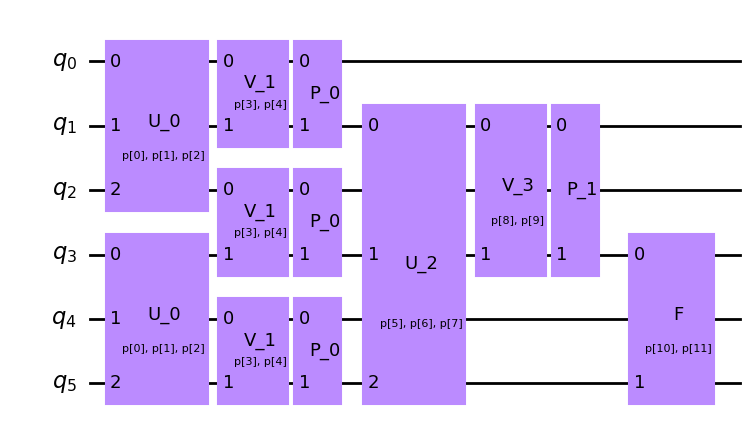

In [3]:
# feature map zum Trainieren:
qcnn_train = qcnn_feature_map(6)

x = ParameterVector("x", 3)
gate_qc = QuantumCircuit(3)
gate_qc.crx(x[0],0,1)
gate_qc.crx(x[2],0,2)
gate_qc.crx(x[1],1,2)

y = ParameterVector("y", 2)
gate_conv2 = QuantumCircuit(2)
gate_conv2.crz(y[0],0,1)
gate_conv2.crz(y[1],1,0)

pooling_gate1 = QuantumCircuit(2)
pooling_gate1.cx(0,1)

# Fully für 2 Qubits
#Alt:
# a = ParameterVector("a",2)
# fully_gate = QuantumCircuit(2)
# fully_gate.rx(a[0],0)
# fully_gate.rx(a[1],1)
a = ParameterVector("a",2)
fully_gate = QuantumCircuit(2)
fully_gate.crx(a[0],0,1)
fully_gate.crx(a[1],1,0)

#Fully für 3 Qubits
b = ParameterVector("b",3)
fully_gate2 = QuantumCircuit(3)
fully_gate2.rx(b[0],0)
fully_gate2.rx(b[1],2)
fully_gate2.rx(b[2],1)


qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = False)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)

qcnn_train.pooling(pooling_gate1,operator="P")

qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = False)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)

qcnn_train.pooling(pooling_gate1,operator="P")
qcnn_train.fully_connected(fully_gate)
#print(qcnn_train.get_qubits_left())
param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()


In [4]:
# Measure |0> state in qubit 3

operator = SingleAmplitude(6,3)
#operator2 = [SingleAmplitude(6,3),SingleAmplitude(6,5)] # measure qubit 3 and 5
print(operator)

0.5 * IIIIII
+ 0.5 * IIZIII


In [5]:
def generate_data_all_combi(length):
    """Creates a 2 dimensional numpy array with all combinations of zeros and ones.
      It outputs this with there labels (0 if more zeros than ones, 1 else)"""
    all_combi_list = list(itertools.product([0,1],repeat=length))
    X_tuple_list = all_combi_list
    X = np.array(X_tuple_list)  #converts list of tuples into a numpy array with dimension 2
    Y = np.count_nonzero(X==0,axis=1) #counts the number of zeros in each sublist
    for i in range(len(Y)):
        zeros = Y[i]
        if 2*zeros > length:
            Y[i] = 0
        else:
            Y[i] = 1 
    return X,Y

def generate_train_data(all_combination_data,train_size):
    """Generates from given all_combination data a train set with there labels."""
    X,Y = all_combination_data[0],all_combination_data[1]
    data_size = Y.size
    index_list = range(data_size)
    index_choice = random.sample(index_list, train_size)
    X_train = np.array([X[i] for i in index_choice])
    Y_train = np.array([Y[i] for i in index_choice])
    return X_train,Y_train

all_combination_data = generate_data_all_combi(6)
X,Y = generate_train_data(all_combination_data,20)
print(all_combination_data)
print((X,Y))

(array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 0],


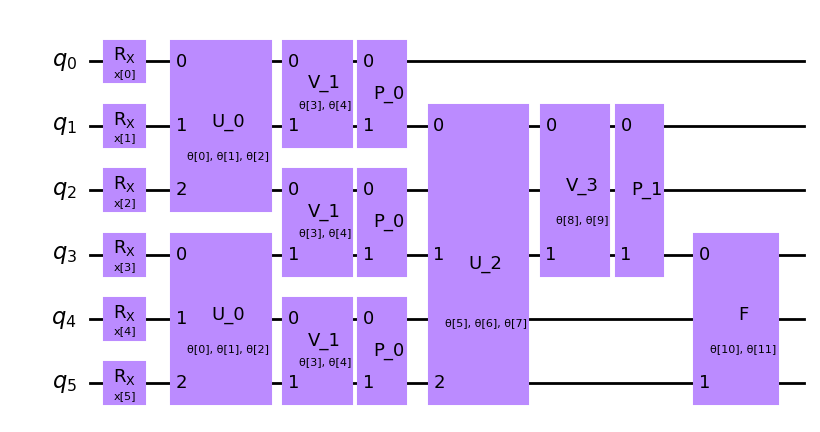

In [6]:
encode = LayeredFeatureMap.from_string("Rx(x)",num_qubits=6,num_features=6)
#qcnn_pqc = encode + qcnn_map
qcnn_pqc = encode + qcnn_train
qcnn_pqc.draw() # TODO: bis zu 10 qubits? oder doch erstmal auf 6 lassen, testen, verschiedene Poolinglayers, U1, Pooling mit mehreren Parametern?, F-layer?

In [7]:
np.random.seed(13) 
param_ini = np.random.rand(qcnn_pqc.num_parameters)
param_op_ini = np.random.rand(operator.num_parameters)
reg = QNNRegressor(qcnn_pqc,
                   operator,
                   Executor(Estimator()),
                   SquaredLoss,
                   SLSQP(),
                   param_ini,
                   param_op_ini,
                   opt_param_op=False,
                    batch_size=10,
    epochs=30,
    shuffle=True,
                   )

c:\users\dkr-ak\documents\projekte lokal\squlearn\src\squlearn\qnn\base_qnn.py:76: UserWarning: SLSQP is not of type SGDMixin, thus batch_size, epochs and shuffle will be ignored.
  warn(


In [8]:
reg.fit(X, Y)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947]
Current value: 5.167390617938397
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947]
Grad length: 0.34368513572522347
grad [ 0.10550579 -0.008799    0.04528941 -0.03360909 -0.06094078 -0.07298148
 -0.02140849  0.00584591  0.02001055 -0.03036413 -0.04609997  0.3012469 ]
theta [ 0.67219662  0.24634022  0.77898912  0.99935829  1.0335419   0.52643073
  0.63045096  0.76968061  0.62160279  0.75238236  0.08113649 -0.00279743]
Current value: 5.058534631637134
theta [ 0.67219662  0.24634022  0.77898912  0.99935829  1.0335419   0.52643073
  0.63045096  0.76968061  0.62160279  0.75238236  0.08113649 -0.00279743]
Grad length: 0.3037100979595461
grad [ 1.18308732e-01  5.80717366e-03  3.89059227e-02 -9.40445457e-02
 -7.21342276e-03 -7.26034510e-02  1.04625145e-04 -3.6672857

In [ ]:
reg.predict([0,0,0,0,0,0])

0.9986125123342583

In [ ]:
X_test = all_combination_data[0]
for i in range(all_combination_data[1].size):
    print(reg.predict(X_test[i]))


0.9986125123342583
0.9986125123342577
0.9986125123342584
0.9986125123342586
0.7525478656574718
0.7509457400603983
0.7533147396557373
0.7536641137882252
0.7694014901489057
0.7694014901489066
0.7694014901489059
0.7694014901489064
0.6316875503045722
0.6309605362747921
0.6318535819288997
0.6320121212446848
0.9986480195204355
0.9986119295212352
0.9986489626897921
[0.99863859]
0.7586888836204935
0.7579182333583141
0.7588894433901314
0.7590422007471476
0.7651316929268956
0.765113543626252
0.7651321672373578
0.7651269484021271
0.6332722406671153
0.6329650073348776
0.6331686253554338
0.6332279304127548
0.961372452580812
0.9613514463320371
0.9613730015542288
0.9613669612029593
0.736892822729138
0.73590879247571
0.737246954095951
0.7374526366770479
0.6780033499577403
0.6780111072459187
0.678003147230207
0.6780053778400604
0.5838102301064574
0.5832216778831357
0.5839152793759629
0.5840469125723137
0.9596031314524714
0.9595655903594165
0.9596041125444468
0.9595933175952149
0.738540938795833
0.73794

In [ ]:
for i in range(all_combination_data[1].size):
    print(reg.predict(X_test[i]))

0.9986125123342583
0.9986125123342577
0.9986125123342584
0.9986125123342586
0.7525478656574718
0.7509457400603983
0.7533147396557373
0.7536641137882252
0.7694014901489057
0.7694014901489066
0.7694014901489059
0.7694014901489064
0.6316875503045722
0.6309605362747921
0.6318535819288997
0.6320121212446848
0.9986480195204355
0.9986119295212352
0.9986489626897921
[0.99863859]
0.7586888836204935
0.7579182333583141
0.7588894433901314
0.7590422007471476
0.7651316929268956
0.765113543626252
0.7651321672373578
0.7651269484021271
0.6332722406671153
0.6329650073348776
0.6331686253554338
0.6332279304127548
0.961372452580812
0.9613514463320371
0.9613730015542288
0.9613669612029593
0.736892822729138
0.73590879247571
0.737246954095951
0.7374526366770479
0.6780033499577403
0.6780111072459187
0.678003147230207
0.6780053778400604
0.5838102301064574
0.5832216778831357
0.5839152793759629
0.5840469125723137
0.9596031314524714
0.9595655903594165
0.9596041125444468
0.9595933175952149
0.738540938795833
0.73794

In [ ]:
print(reg.predict(X_test[19]))
print(X_test[19])

[0.99863859]
[0 1 0 0 1 1]


In [ ]:
reg.predict(X_test)

array([0.99861251, 0.99861251, 0.99861251, 0.99861251, 0.75254787,
       0.75094574, 0.75331474, 0.75366411, 0.76940149, 0.76940149,
       0.76940149, 0.76940149, 0.63168755, 0.63096054, 0.63185358,
       0.63201212, 0.99864802, 0.99861193, 0.99864896, 0.99863859,
       0.75868888, 0.75791823, 0.75888944, 0.7590422 , 0.76513169,
       0.76511354, 0.76513217, 0.76512695, 0.63327224, 0.63296501,
       0.63316863, 0.63322793, 0.96137245, 0.96135145, 0.961373  ,
       0.96136696, 0.73689282, 0.73590879, 0.73724695, 0.73745264,
       0.67800335, 0.67801111, 0.67800315, 0.67800538, 0.58381023,
       0.58322168, 0.58391528, 0.58404691, 0.95960313, 0.95956559,
       0.95960411, 0.95959332, 0.73854094, 0.73794903, 0.73862313,
       0.73873629, 0.67248337, 0.67247299, 0.67248364, 0.67248066,
       0.58368468, 0.58354077, 0.58348047, 0.58350746])